In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_excel('C:\\Users\\user\\Desktop\\Online Retail.xlsx')

In [5]:
df.shape

(541909, 8)

In [6]:
data=df.sample(5000, random_state=0)

In [7]:
data.shape

(5000, 8)

In [8]:
data.isnull().sum()

InvoiceNo         0
StockCode         0
Description       8
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1196
Country           0
dtype: int64

#### For customer segmentation, CustomerID is a key therefore it can't be null. So dropping the rows with null CustomerID

In [9]:
data=data.dropna(axis=0)


In [10]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
data.shape

(3804, 8)

In [12]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
387967,570410,22396,MAGNETS PACK OF 4 RETRO PHOTO,1,2011-10-10 13:04:00,0.39,16776.0,United Kingdom
510721,579467,23560,SET OF 6 RIBBONS COUNTRY STYLE,6,2011-11-29 14:57:00,2.89,15755.0,United Kingdom
437992,574301,20749,ASSORTED COLOUR MINI CASES,4,2011-11-03 16:15:00,7.95,12544.0,Spain
166468,550921,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2011-04-21 14:21:00,0.55,14770.0,United Kingdom
279431,561322,23204,CHARLOTTE BAG APPLES DESIGN,10,2011-07-26 13:03:00,0.85,15203.0,United Kingdom


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3804 entries, 387967 to 240243
Data columns (total 8 columns):
InvoiceNo      3804 non-null object
StockCode      3804 non-null object
Description    3804 non-null object
Quantity       3804 non-null int64
InvoiceDate    3804 non-null datetime64[ns]
UnitPrice      3804 non-null float64
CustomerID     3804 non-null float64
Country        3804 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 267.5+ KB


In [19]:
import datetime

In [25]:
# performing RFM segmentation -- Recency, Frequency, and MonetaryValue
# for recency column-- subtract the snapshot date with the date where the transaction occurred
snapshot_date=max(data.InvoiceDate)+datetime.timedelta(days=1)
data["Total Sum"]=data["UnitPrice"]+data["Quantity"]

In [26]:
# converging data by each customer
customers = data.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'Total Sum': 'sum'})


In [27]:
# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'Total Sum': 'MonetaryValue'}, inplace=True)

In [31]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,130,4,46.60
12349.0,19,1,14.10
12356.0,245,1,9.25
12357.0,33,3,55.32
12359.0,57,1,10.25


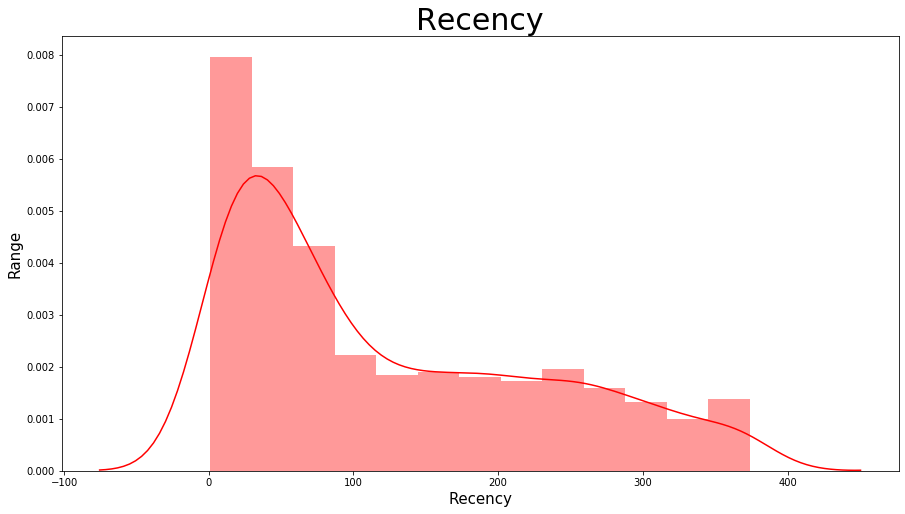

In [35]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.distplot(customers['Recency'], color = 'red')
plt.title('Recency', fontsize = 30)
plt.xlabel('Recency', fontsize = 15)
plt.ylabel('Range', fontsize = 15)
plt.show()

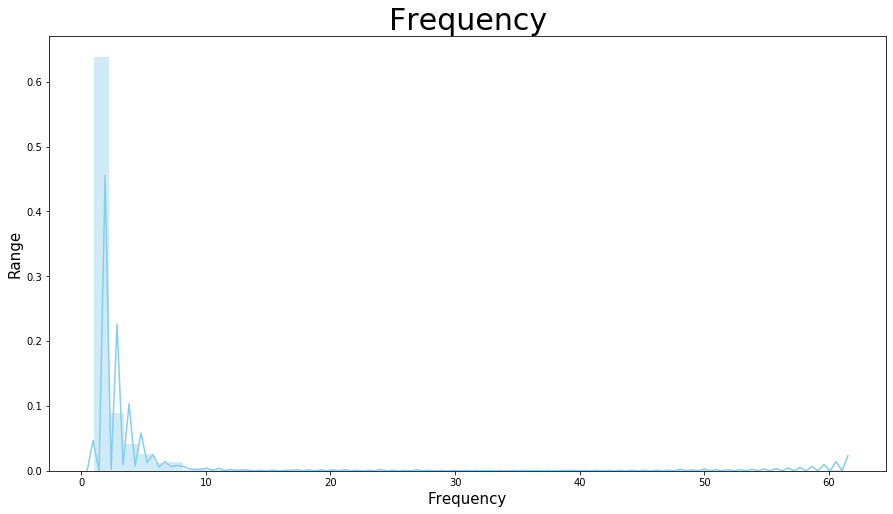

In [36]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.distplot(customers['Frequency'], color = 'skyblue')
plt.title('Frequency', fontsize = 30)
plt.xlabel('Frequency', fontsize = 15)
plt.ylabel('Range', fontsize = 15)
plt.show()

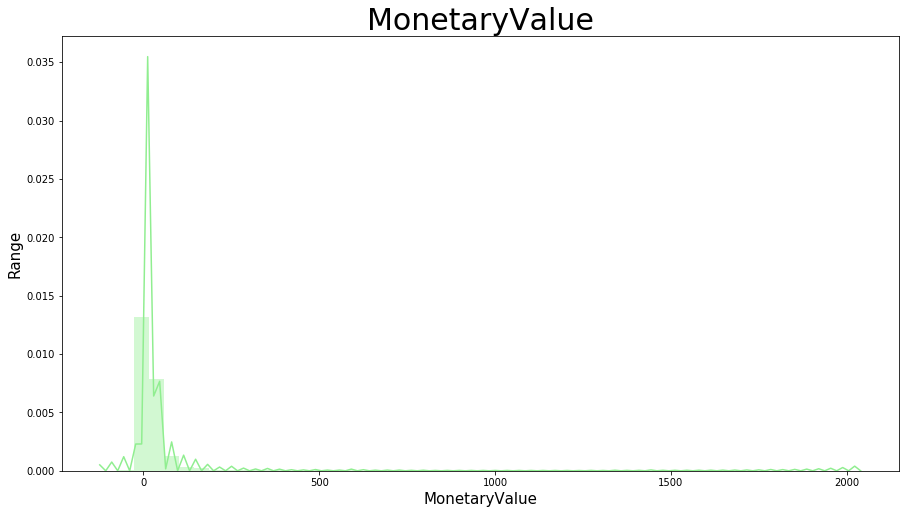

In [38]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.distplot(customers['MonetaryValue'], color = 'lightgreen')
plt.title('MonetaryValue', fontsize = 30)
plt.xlabel('MonetaryValue', fontsize = 15)
plt.ylabel('Range', fontsize = 15)
plt.show()

## Hence from the above graph we can see that data is skewed

In [29]:
from scipy import stats

In [39]:
# removing skewness of the data
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
1746,4.617097,0.000000,-0.629961
1747,8.842022,0.000000,2.220605
1748,12.613528,0.000000,2.618313
1749,4.339917,0.701202,2.123101
1750,8.037970,0.481005,3.955123


In [40]:
# Normalization
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[0. 0. 0.]
[1. 1. 1.]


In [44]:
customers_normalized

array([[ 0.3910677 ,  1.42707317,  0.74465054],
       [-1.1066481 , -0.87165093, -0.22535305],
       [ 1.10836353, -0.87165093, -0.48509864],
       ...,
       [ 0.74852538, -0.87165093, -0.05931421],
       [-1.2028186 ,  1.42707317, -0.46546983],
       [-0.33062703,  0.70520731,  1.03709241]])

# Modelling

In [43]:
from sklearn.cluster import KMeans

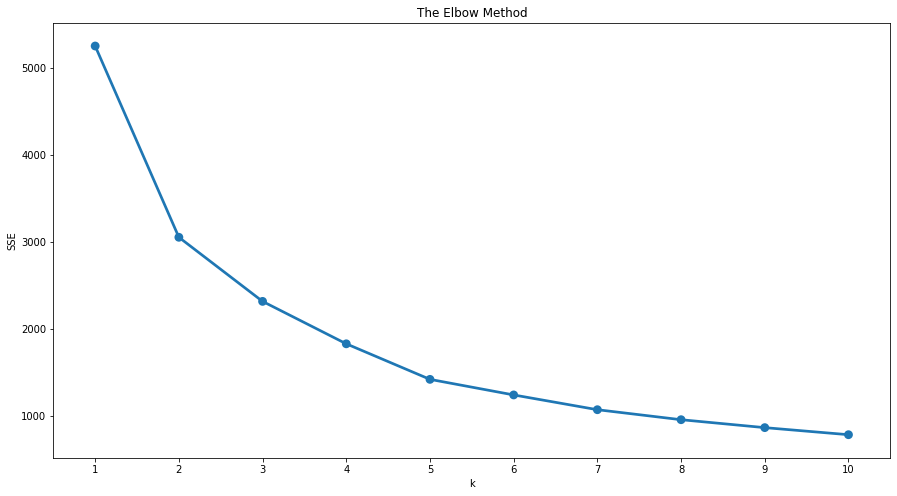

In [45]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### The x-axis is the value of the k, and the y-axis is the SSE value of the data. We will take the best parameter by looking at where the k-value will have a linear trend on the next consecutive k.

In [46]:
#k=3
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(1751,)

In [47]:
# summarizing the RFM based on clusters and calculate the mean of each variable. 
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)


Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        239.68      1.19         14.62   630
1         45.20      1.01         11.32   441
2         65.36      3.83         67.98   680

# Hierarchical Clustering and dendogram

In [57]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

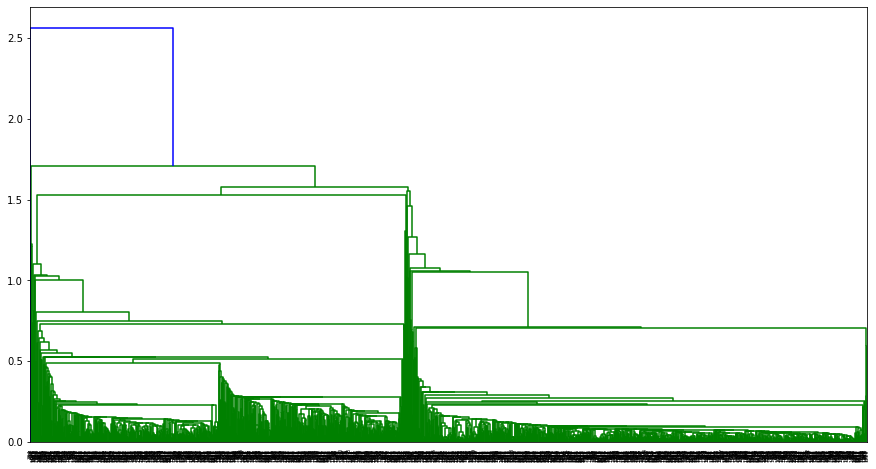

In [58]:
mergings = linkage(customers_normalized, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

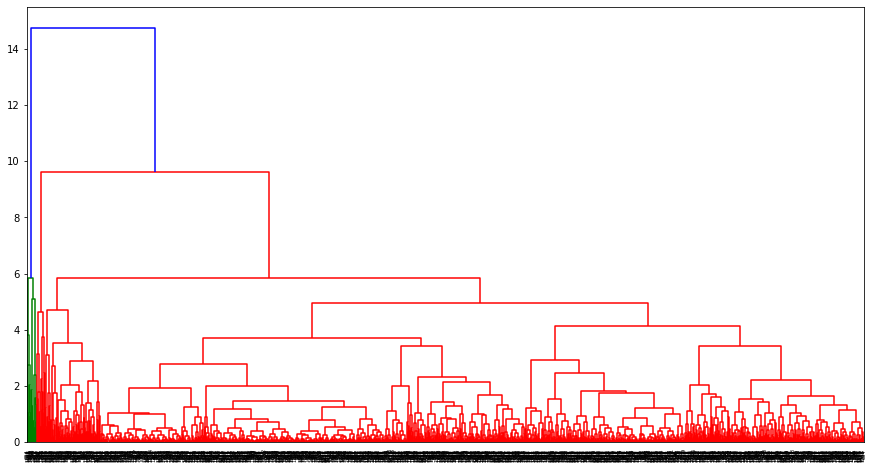

In [59]:
# Complete linkage
mergings = linkage(customers_normalized, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [60]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [61]:

customers['Cluster_Labels'] = cluster_labels
customers.head()

,Recency,Frequency,MonetaryValue,Cluster,Cluster_Labels
CustomerID,,,,,
12347.0,130,4,46.60,2,0
12349.0,19,1,14.10,1,0
12356.0,245,1,9.25,0,0
12357.0,33,3,55.32,2,0
12359.0,57,1,10.25,1,0


In [70]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 3).reshape(-1,))
RFM_hc = pd.concat([customers, clusterCut], axis=1)
RFM_hc.columns = ['CustomerID','Recency','Frequency', 'MonetaryValue','ClusterID', 'Cluster_Labels']

In [71]:
RFM_hc.head()

,CustomerID,Recency,Frequency,MonetaryValue,ClusterID,Cluster_Labels
0.0,NaN,NaN,NaN,NaN,NaN,0.0
1.0,NaN,NaN,NaN,NaN,NaN,0.0
2.0,NaN,NaN,NaN,NaN,NaN,0.0
3.0,NaN,NaN,NaN,NaN,NaN,0.0
4.0,NaN,NaN,NaN,NaN,NaN,0.0


In [75]:
RFM_hc.Recency = RFM_hc.Recency
km_clusters_monetaryvalue =pd.DataFrame(RFM_hc.groupby(["ClusterID"]).MonetaryValue.mean())
km_clusters_frequency = pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Recency.mean())

In [79]:
df1 = pd.concat([pd.Series([0,1,2]), km_clusters_monetaryvalue, km_clusters_frequency, km_clusters_recency], axis=1)
df1.columns = ["ClusterID", "MV_mean", "Frequency_mean", "Recency_mean"]
df1.head()

,ClusterID,MV_mean,Frequency_mean,Recency_mean
0,0,1.022183,26.103333,2.007005
1,1,2.000000,760.670476,16.428571
2,2,0.470588,-15.590588,1.235294


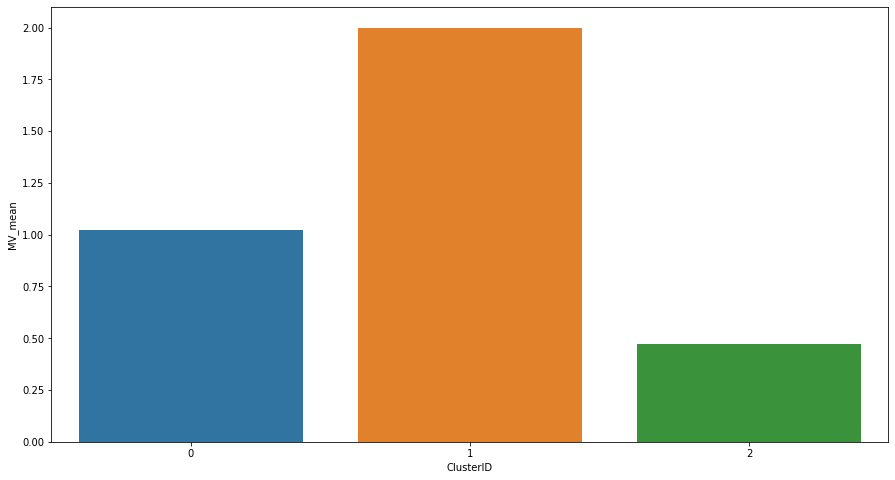

In [82]:
sns.barplot(x=df1.ClusterID, y=df1.MV_mean)

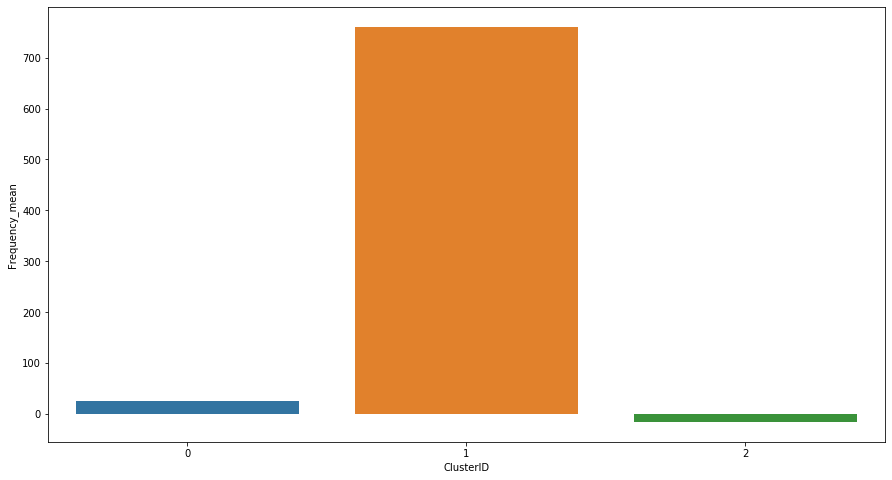

In [83]:
sns.barplot(x=df1.ClusterID, y=df1.Frequency_mean)

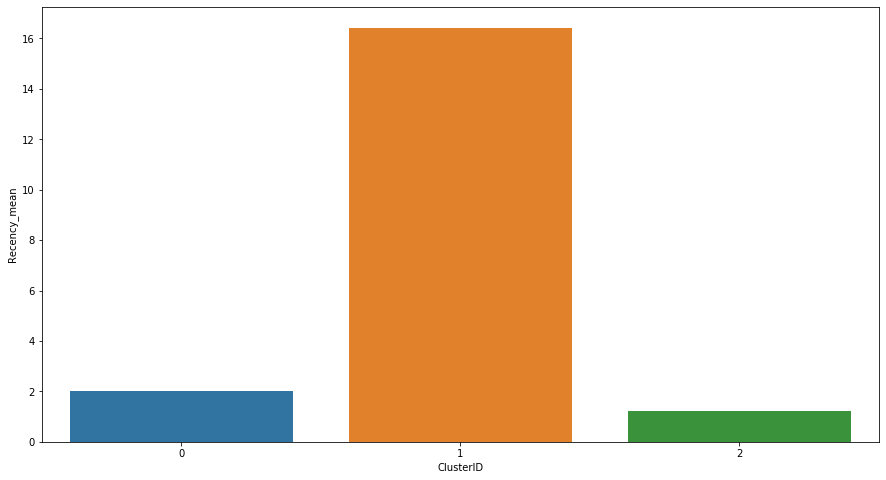

In [84]:
sns.barplot(x=df1.ClusterID, y=df1.Recency_mean)